In [240]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load Libraries

In [241]:
# git clone ondyari-FaceForensics_-_2019-09-27_00-21-31.bundle 

In [242]:
import numpy as np
import pandas as pd
import os 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import cv2 as cv

# Load Dataset

In [243]:
DATA_FOLDER = '/kaggle/input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = '/kaggle/input/deepfake-detection-challenge/train_sample_videos'
TEST_FOLDER = '/kaggle/input/deepfake-detection-challenge/test_videos'

print(f"Train Samples: {len(os.listdir(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER)))}")
print(f"Test Samples: {len(os.listdir(os.path.join(DATA_FOLDER,TEST_FOLDER)))}")
                            

Train Samples: 401
Test Samples: 400
Train Samples: 401
Test Samples: 400


In [244]:
FACE_DETECTION_FOLDER = '/kaggle/input/haar-cascades-for-face-detection'
print(f"face detection resources: {os.listdir(os.path.join(FACE_DETECTION_FOLDER))}")


face detection resources: ['haarcascade_upperbody.xml', 'haarcascade_eye.xml', 'haarcascade_frontalface_default.xml', 'haarcascade_eye_tree_eyeglasses.xml', 'haarcascade_fullbody.xml', 'haarcascade_frontalface_alt_tree.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_smile.xml', 'haarcascade_profileface.xml', 'haarcascade_frontalface_alt2.xml']


In [245]:
train_list = list(os.listdir(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions : {ext_dict}")

Extensions : ['mp4', 'json']


In [246]:
# r file_ext in ext_dict:
#     print(f"Files with extension '{file_ext}': {len([file for file in train_list if file.endswith(file_ext)])}")

In [247]:
test_list = list(os.listdir(os.path.join(DATA_FOLDER,TEST_FOLDER)))
ext_dict = []
for file in test_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")
for file_ext in ext_dict:
    print(f"Files with extensions '{file_ext}':{len([file for file in train_list if file.endswith(file_ext)])}")
    

Extensions: ['mp4']
Files with extensions 'mp4':400


In [248]:
json_file = [file for file in train_list if file.endswith('json')][0]
print(f"JSON file : {json_file}")

JSON file : metadata.json


In [249]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER,path,json_file))
    df = df.T
    return df
meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [250]:
def missing_data(data):
        total = data.isnull().sum()
        percent = (data.isnull().sum()/data.isnull().count()*100)
        tt = pd.concat([total,percent],axis = 1,keys = ['Total','Percent'])
        types = []
        for col in data.columns:
            dtype = str(data[col].dtype)
            types.append(dtype)
        tt['Types'] = types
        return(np.transpose(tt))

In [251]:
missing_data(meta_train_df.loc[meta_train_df.label == 'REAL'])

,label,split,original
Total,0,0,77
Percent,0.0,0.0,100.0
Types,object,object,object


In [252]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [253]:
unique_values(meta_train_df)

,label,split,original
Total,400,400,323
Uniques,2,1,209


In [254]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [255]:
most_frequent_values(meta_train_df)

,label,split,original
Total,400,400,323
Most frequent item,FAKE,train,atvmxvwyns.mp4
Frequence,323,400,6
Percent from total,80.75,100.0,1.858


In [256]:
def plot_count(feature,title,df,size=1):
    f,ax = plt.subplots(1,1, figsize = (4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature],order = df[feature].value_counts().index[:20],palette = 'Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation = 90, size = 8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:1,2f}%',format(100*height/total),
               ha = "center")
    plt.show()

In [257]:
# %pip install plot_functions

In [258]:
# plot_count('split','split(train)',meta_train_df)
# Import the necessary modules
# import plot_functions as plot
import pandas as pd

# Assuming meta_train_df is a DataFrame containing the metadata of the train split

# Define the function to plot the count of each category in a column
def plot_count(column, subset, df):
    # Create a sub-DataFrame containing only the rows that match the subset condition
    sub_df = df.loc[df[column] == subset]
    
    # Create a count plot of the 'split' column in the sub-DataFrame
#     plot.count_plot(sub_df['split'])

# Call the function with the 'split' column, 'split(train)' subset, and meta_train_df DataFrame
plot_count('split','split(train)',meta_train_df)

In [259]:
plot_count('label','label(train)',meta_train_df)

In [260]:
meta = np.array(list(meta_train_df.index))
storage = np.array([file for file in train_list if file.endswith('mp4')])
print(f" Metadata: {meta.shape[0]},Folder: {storage.shape[0]}")
print(f" Files in metadata and not in folder: {np.setdiff1d(meta,storage,assume_unique = False).shape[0]}")
print(f" Files in folder and not in metadata: {np.setdiff1d(storage,meta,assume_unique = False).shape[0]}")


 Metadata: 400,Folder: 400
 Files in metadata and not in folder: 0
 Files in folder and not in metadata: 0


In [261]:
fake_train_sample_video = list(meta_train_df.loc[meta_train_df.label == 'FAKE'].sample(3).index)
fake_train_sample_video

['cfyduhpbps.mp4', 'ehevsxtecd.mp4', 'cxttmymlbn.mp4']

In [262]:
def display_image_from_video(video_path):
    capture_image = cv.VideoCapture(video_path)
    ret,frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
    ax.imshow(frame)

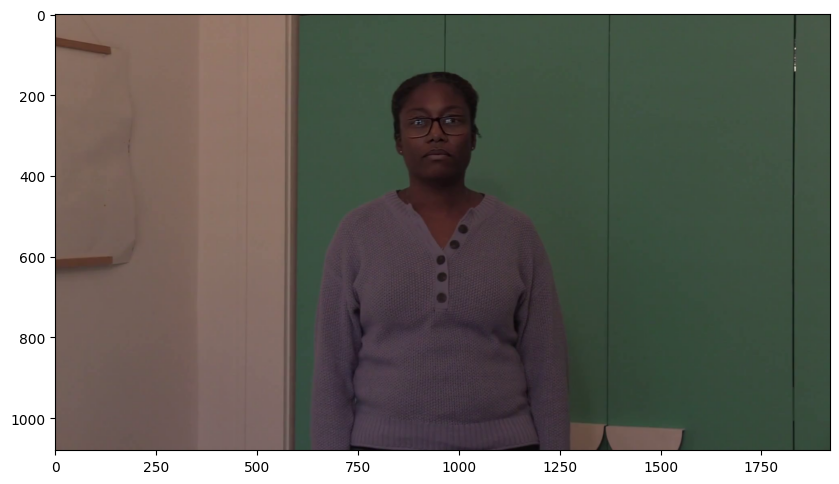

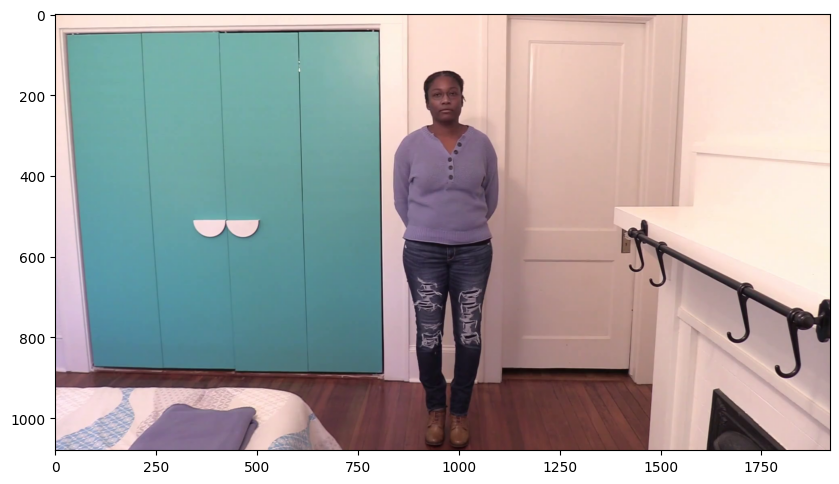

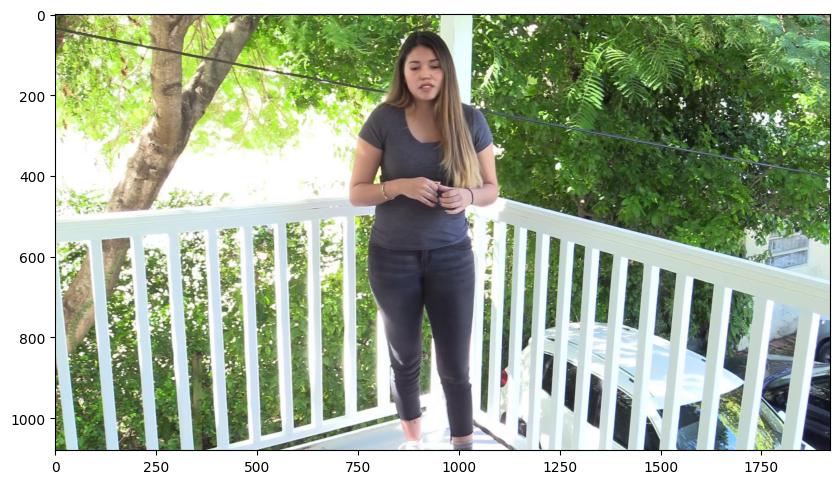

In [263]:
for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER,video_file))
    

In [264]:
real_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='REAL'].sample(3).index)
real_train_sample_video

['atkdltyyen.mp4', 'edyncaijwx.mp4', 'cppdvdejkc.mp4']

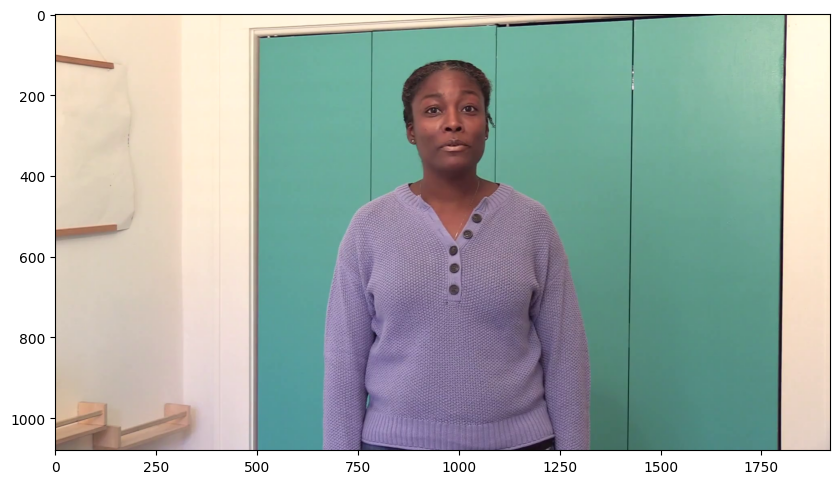

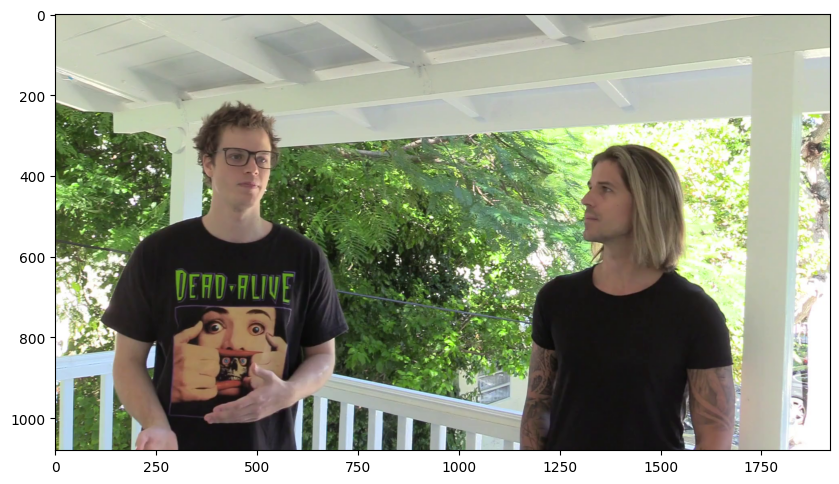

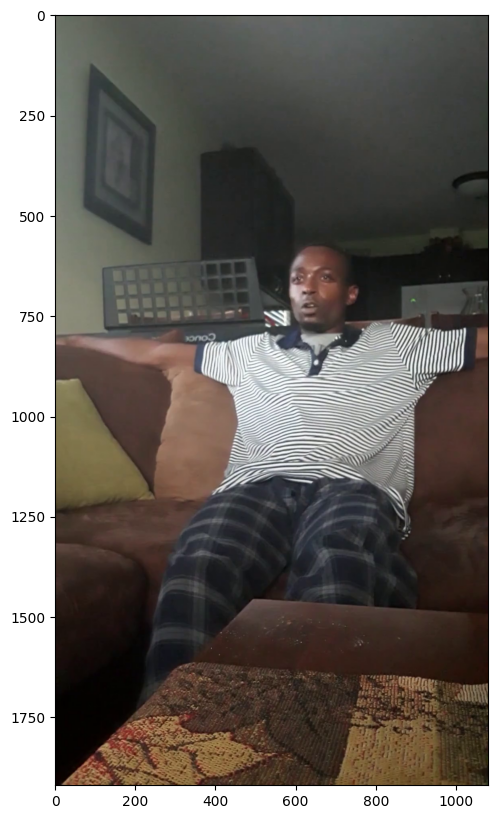

In [265]:
for video_file in real_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [266]:
meta_train_df['original'].value_counts()[0:5]

original
atvmxvwyns.mp4    6
meawmsgiti.mp4    6
qeumxirsme.mp4    5
kgbkktcjxf.mp4    5
fysyrqfguw.mp4    4
Name: count, dtype: int64

In [43]:
def display_image_from_video_list(video_path_list, video_folder = TRAIN_SAMPLE_FOLDER):
    plt.figure()
    fig,ax = plt.subplots(2,3,figsize = (16,8))
    for i,video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER,video_folder,video_file)
        capture_image = cv.VideoCapture(video_path)
        ret,frame = capture_image.read()
        frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')

<Figure size 1600x800 with 0 Axes>

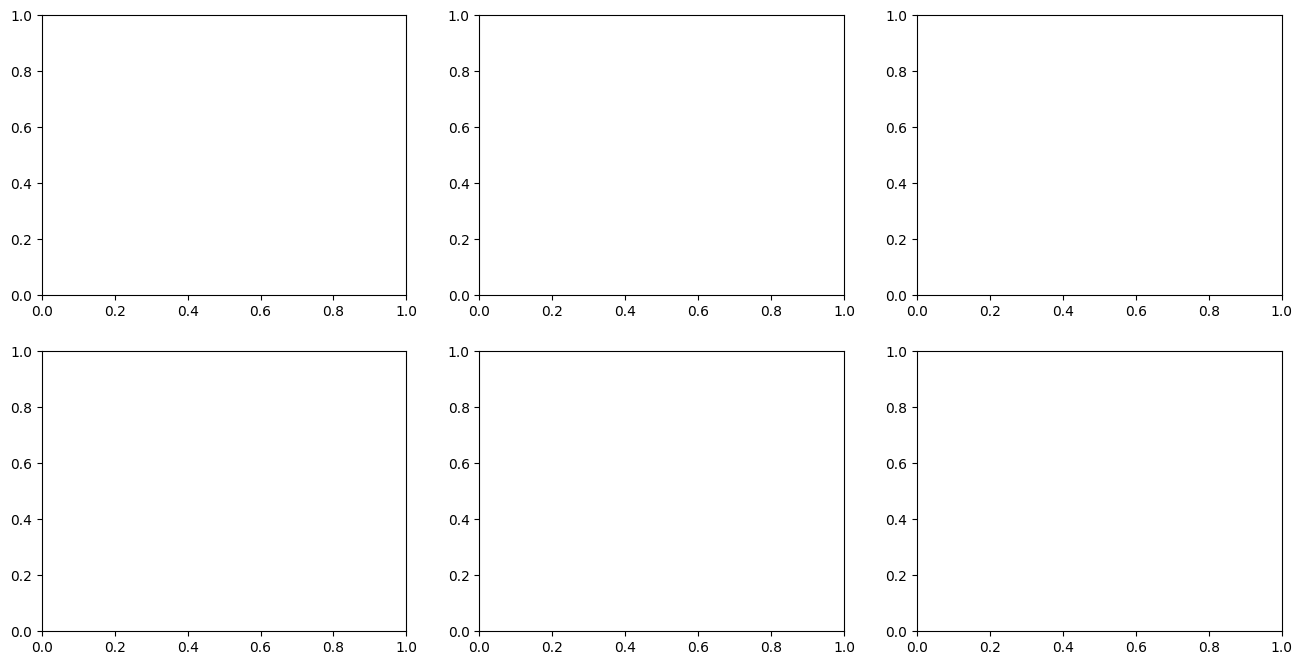

In [44]:
# same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='apedduehoy.mp4'].index)
# display_image_from_video_list(same_original_fake_train_sample_video)
import os
import cv2
import matplotlib.pyplot as plt

TRAIN_SAMPLE_FOLDER = 'train_sample'

def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    plt.figure(figsize=(16, 8))
    fig, ax = plt.subplots(2, 3, figsize=(16, 8))
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder, video_file)
        capture_image = cv2.VideoCapture(video_path)
        ret, frame = capture_image.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax[i // 3, i % 3].imshow(frame)
        ax[i // 3, i % 3].set_title(f"Video: {video_file}")
        ax[i // 3, i % 3].axis('on')

# Define the DATA_FOLDER variable
DATA_FOLDER = 'data'

# Use the loc method to filter the meta_train_df DataFrame
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='apedduehoy.mp4'].index)

# Call the display_image_from_video_list function with the filtered indices
display_image_from_video_list(same_original_fake_train_sample_video)